In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
from glob import glob
import pickle

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate, KFold

from rogi import RoughnessIndex, MODI

from tdc.generation import MolGen
from tdc import Oracle
from tdc.single_pred import ADME, Tox

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style='ticks')

In [2]:
def compute_rdkit_descriptors(smi):
    m = Chem.MolFromSmiles(smi)
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    descriptor_funcs = [desc[1] for desc in Descriptors.descList]
    descriptors = [desc(m) for desc in descriptor_funcs]
    return descriptors


def smiles_to_descriptors_df(smiles, descriptors=None):
    Xdict = {}
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for desc in Descriptors.descList:
        name = desc[0]
        f = desc[1]

        if descriptors is not None and name in descriptors:
            Xdict[name] = [f(m) for m in mols]
    return pd.DataFrame(Xdict)
    

def plot_scatter(ax, x, y, title='', marker='X', s=100, 
                 fit=False, fit_outline=True, fit_lw=1, fit_zorder=0,
                 color='b', edgecolor='k', linewidth=0.5, alpha_face=1, alpha_edge=1,
                 annotate=True, text_color='k', x_text=0.55, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label=''):

    if fit:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d( coef)
        if fit_outline:
            ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='-', color='white', zorder=fit_zorder-1, linewidth=fit_lw+1)
        ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='--', color=color, zorder=fit_zorder, linewidth=fit_lw)

    # face
    ax.scatter(x, y, marker=marker, s=s, color=color, edgecolor='none', linewidth=0, alpha=alpha_face, zorder=zorder_scatter, label=label)
    # edges
    ax.scatter(x, y, marker=marker, s=s, facecolor="none", edgecolor=edgecolor, linewidth=linewidth, alpha=alpha_edge, zorder=zorder_scatter)

    ax.set_title(title)

    if annotate:
        pears = pearsonr(x, y)[0]
        _ = ax.annotate(f'$r = {pears:.2f}$', xy=(x_text, y_text), xycoords='axes fraction', ha='right', color=text_color, fontsize=fontsize,
                        zorder=10, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
        

def binarize_dataset(y, balance=0.5):
    y = np.array(y)
    thres = np.percentile(y, balance * 100)
    y_bin = np.where(y > thres, 1., 0.)
    return y_bin

In [3]:
# ----------------
# Guacamol Oracles
# ----------------
# NOTE: we do not use "Sitagliptin_MPO" because it returns NaNs for some SMILES
# we exclude also "Valsartan_SMARTS" becuase Y is always 0
oracle_names = ['QED', 'LogP', 'Celecoxib_Rediscovery', 'Aripiprazole_Similarity', 'Median 1', 
                'Osimertinib_MPO', 'Fexofenadine_MPO', 'Ranolazine_MPO', 'Perindopril_MPO', 
                'Amlodipine_MPO', 'Zaleplon_MPO', 'Scaffold Hop']

# ------------------------
# TDC regression datasets
# ------------------------
adme_props = [('Caco2_Wang', None), 
              ('Lipophilicity_AstraZeneca', None), 
              ('Solubility_AqSolDB', None), 
              ('HydrationFreeEnergy_FreeSolv', None), 
              ('PPBR_AZ', None), 
              ('VDss_Lombardo', None),
              ('Half_Life_Obach', None), 
              ('Clearance_Hepatocyte_AZ', None), 
              ('Clearance_Microsome_AZ', None)]

tox_props = [('LD50_Zhu', None),
             ('herg_central', 'hERG_at_1uM'), 
             ('herg_central', 'hERG_at_10uM')]

# combine
props = []
props.extend(adme_props)
props.extend(tox_props)

# def func to get TDC dataset
def get_tdc_dataset(name, label_name):
        
    if (name, label_name) in adme_props:
        df = ADME(name=name, label_name=label_name).get_data()
    elif (name, label_name) in tox_props:
        df = Tox(name=name, label_name=label_name).get_data()
    else:
        raise ValueError(f'Cannot understand {name}, {label_name}')
        
    # subsample
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    
    return df

# -----------------
# ML models to use
# -----------------
models = {'KNN': KNeighborsClassifier(), # neirest neighbor 
          'LR': LogisticRegression(random_state=42), # linear model
          'RF': RandomForestClassifier(n_estimators=50, n_jobs=12, random_state=42), # tree-based
          'SVC': SVC(random_state=42), # kernel method
          'MLP': MLPClassifier(random_state=42) # neural network
          }

# --------------------------------------------
# select a bunch of commonly-used descriptors
# --------------------------------------------
desc_names = ['MolWt', 'FractionCSP3', 'NumHAcceptors', 'NumHDonors', 'NOCount', 'NHOHCount',
              'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
              'NumRotatableBonds', 'TPSA', 'qed', 'MolLogP']

# -----------------------------
# Dict use to store all results
# -----------------------------
RESULTS = {}
RESULTS['ZINC'] = {}
RESULTS['TDC'] = {}
RESULTS['CHEMBL'] = {}

## ZINC + Guacamol

In [4]:
# sample 2000 molecules at random from ZINC
data = MolGen(name='ZINC')
data_sample = data.get_data().sample(n=2000, replace=False, random_state=42)
smiles = data_sample.loc[:, 'smiles'].to_numpy()

Found local copy...
Loading...
Done!


In [5]:
# =============
# FINGERPRINTS
# =============

RESULTS['ZINC']['FPS'] = {}

for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['FPS'][name] = {}
    
    oracle = Oracle(name=name)
    Y = oracle(list(smiles))
    
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['ZINC']['FPS'][name]['size'] = len(Y)
    
    # instantiate rogi object
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
        
    # compute RI score
    RESULTS['ZINC']['FPS'][name]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['ZINC']['FPS'][name]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['ZINC']['FPS'][name][model_name] = cv_results
    print()

QED
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...



LogP
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF SVC MLP 
Celecoxib_Rediscovery
  -->  KNN LR RF SVC MLP 
Aripiprazole_Similarity
  -->  KNN LR RF SVC MLP 
Median 1
  -->  KNN LR RF SVC MLP 
Osimertinib_MPO
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF SVC MLP 
Fexofenadine_MPO
  -->  KNN LR RF SVC MLP 
Ranolazine_MPO
  -->  KNN LR RF SVC MLP 
Perindopril_MPO
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
Amlodipine_MPO
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
Zaleplon_MPO
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
Scaffold Hop
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF SVC MLP 


In [6]:
# ===========
# DESCRIPTORS
# ===========

RESULTS['ZINC']['DESC'] = {}

# ----------------
# get descriptors 
# ----------------
descriptor_funcs = {desc[0]:desc[1] for desc in Descriptors.descList}
X = []
for smi in smiles:
    m = Chem.MolFromSmiles(smi)
    Xi = []
    for desc_name in desc_names:
        desc = descriptor_funcs[desc_name](m)
        Xi.append(desc)
    X.append(Xi)

X = np.array(X)
# normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
_X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# ----------------

for name in oracle_names:
    print(f'{name}')
    RESULTS['ZINC']['DESC'][name] = {}
    
    oracle = Oracle(name=name)
    Y = oracle(list(smiles))
    
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['ZINC']['DESC'][name]['size'] = len(Y)
    
    # compute RI score
    ri = RoughnessIndex(Y=Y, X=_X, metric='euclidean', verbose=False)
    RESULTS['ZINC']['DESC'][name]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['ZINC']['DESC'][name]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['ZINC']['DESC'][name][model_name] = cv_results
    print()

QED
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


LogP
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Celecoxib_Rediscovery
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Aripiprazole_Similarity
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Median 1
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Osimertinib_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Fexofenadine_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Ranolazine_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Perindopril_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Amlodipine_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Zaleplon_MPO
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Scaffold Hop
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## TDC Datasets

In [7]:
# ============
# FINGERPRINTS
# ============

RESULTS['TDC']['FPS'] = {}

for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['FPS'][tag] = {}
    print(tag)

    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['TDC']['FPS'][tag]['size'] = len(data)

    # compute RI score
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
    RESULTS['TDC']['FPS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['TDC']['FPS'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['TDC']['FPS'][tag][model_name] = cv_results
    print()

Found local copy...
Loading...
Done!


Caco2_Wang_None
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



Lipophilicity_AstraZeneca_None
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...
Done!



Solubility_AqSolDB_None


[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not removing hydrogen atom without neighbors
[10:22:00] WARNING: not r

  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...
Done!



HydrationFreeEnergy_FreeSolv_None
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



PPBR_AZ_None
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...
Done!



VDss_Lombardo_None
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



Half_Life_Obach_None
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



Clearance_Hepatocyte_AZ_None
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...
Done!



Clearance_Microsome_AZ_None
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...
Done!



LD50_Zhu_None
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...



herg_central_hERG_at_1uM


Done!


  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 

Found local copy...
Loading...



herg_central_hERG_at_10uM


Done!


  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 


In [8]:
# ===========
# DESCRIPTORS
# ===========

RESULTS['TDC']['DESC'] = {}

for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['DESC'][tag] = {}
    print(tag)

    # data
    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['TDC']['DESC'][tag]['size'] = len(data)
    
    # descriptors
    df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
    # normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
    X = df_X.to_numpy()
    _X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # compute RI score
    ri = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False)        
    RESULTS['TDC']['DESC'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['TDC']['DESC'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['TDC']['DESC'][tag][model_name] = cv_results
    print()

Found local copy...
Loading...
Done!


Caco2_Wang_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Lipophilicity_AstraZeneca_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Solubility_AqSolDB_None


[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not removing hydrogen atom without neighbors
[10:38:48] WARNING: not r

  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


HydrationFreeEnergy_FreeSolv_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


PPBR_AZ_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


VDss_Lombardo_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Half_Life_Obach_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Clearance_Hepatocyte_AZ_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Clearance_Microsome_AZ_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


LD50_Zhu_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


herg_central_hERG_at_1uM


Done!


  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Found local copy...
Loading...



herg_central_hERG_at_10uM


Done!


  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## ChEMBL Datasets

In [9]:
csv_files = glob('chembl_datasets/*csv')

In [10]:
RESULTS['CHEMBL']['FPS'] = {}

for csv_file in csv_files:
    tag = csv_file.split('/')[-1].strip('.csv')
    RESULTS['CHEMBL']['FPS'][tag] = {}
    print(tag)

    # load csv
    data = pd.read_csv(csv_file, index_col=0)
    # rm NaN entries
    data = data.dropna()
    smiles = data.loc[:, 'smiles']
    # take log affinity
    Y =  - np.log10(data.loc[:, 'exp_mean [nM]'].to_numpy() * 10 **(-9))
    
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['CHEMBL']['FPS'][tag]['size'] = len(data)

    # compute RI score
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)
    RESULTS['CHEMBL']['FPS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['CHEMBL']['FPS'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['CHEMBL']['FPS'][tag][model_name] = cv_results
    print()

CHEMBL2034_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL219_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL2147_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL236_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL3979_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL2835_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL264_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL238_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL1871_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL2971_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL233_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL262_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL287_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL4005_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL4203_Ki
  -->  KNN LR RF SVC MLP 
CHEMBL214_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL237_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL218_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL4792_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL228_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL231_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL204_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL4616_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL239_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL244_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL237_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL2047_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL1862_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF SVC MLP 
CHEMBL234_Ki
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 
CHEMBL235_EC50
  -->  KNN LR 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

RF SVC MLP 


In [11]:
RESULTS['CHEMBL']['DESC'] = {}

for csv_file in csv_files:
    tag = csv_file.split('/')[-1].strip('.csv')
    RESULTS['CHEMBL']['DESC'][tag] = {}
    print(tag)

    # load csv
    data = pd.read_csv(csv_file, index_col=0)
    # rm NaN entries
    data = data.dropna()
    smiles = data.loc[:, 'smiles']
    # take log affinity
    Y =  - np.log10(data.loc[:, 'exp_mean [nM]'].to_numpy() * 10 **(-9))
    # binarize dataset
    Y = binarize_dataset(Y, balance=0.5)
    
    RESULTS['CHEMBL']['DESC'][tag]['size'] = len(data)
    
    # descriptors
    df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
    # normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
    X = df_X.to_numpy()
    _X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # compute RI score
    ri = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False) 
    RESULTS['CHEMBL']['DESC'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['CHEMBL']['DESC'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['CHEMBL']['DESC'][tag][model_name] = cv_results
    print()

CHEMBL2034_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL219_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL2147_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL236_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL3979_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL2835_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL264_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL238_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL1871_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL2971_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL233_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL262_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL287_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL4005_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL4203_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL214_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL237_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL218_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL4792_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL228_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL231_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL204_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL4616_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL239_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL244_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL237_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL2047_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL1862_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL234_Ki
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CHEMBL235_EC50
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
with open('binarized_regression_results.pkl', 'wb') as f:
    pickle.dump(RESULTS, f)

In [5]:
with open('binarized_regression_results.pkl', 'rb') as f:
    RESULTS = pickle.load(f)

## Plot results

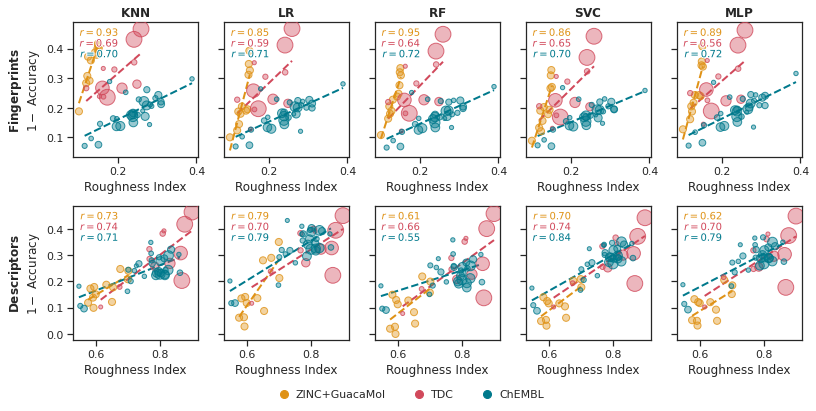

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11.5, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

METRIC = 'test_accuracy'
s = 'rogi'    

REPR = 'FPS'
# --------------------
# ZINC + FINGERPRINTS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, 1. - accuracy, title=f'$\\bf{m}$', marker='o', s=50, # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + FINGERPRINTS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, 1. - accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + FINGERPRINTS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, 1. - accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
REPR = 'DESC'
# --------------------
# ZINC + DESCRIPTORS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, 1. - accuracy, title='', marker='o', s=50, 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + DESCRIPTORS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, 1. - accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + DESCRIPTORS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, 1. - accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\n$1-$ Accuracy')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\n$1-$ Accuracy')

for i in range(2):
    for j in range(5):
        axes[i,j].set_xlabel("Roughness Index")
        axes[i,j].set_xlabel("Roughness Index")


# legend
ms = 8
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label='ZINC+GuacaMol', markerfacecolor=colors[0], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label='TDC', markerfacecolor=colors[1], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label='ChEMBL', markerfacecolor=colors[2], markersize=ms)]

#fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
lgd = fig.legend(handles=legend_elements, loc='lower center', ncol=3, handletextpad=0.1,
                 bbox_to_anchor=(0.5, -0.05), frameon=False, bbox_transform=fig.transFigure)

plt.tight_layout()
fig.savefig(f'plots/binarized_regression-{s}.pdf', bbox_inches='tight')
fig.savefig(f'plots/binarized_regression-{s}.png', dpi=600, bbox_inches='tight')

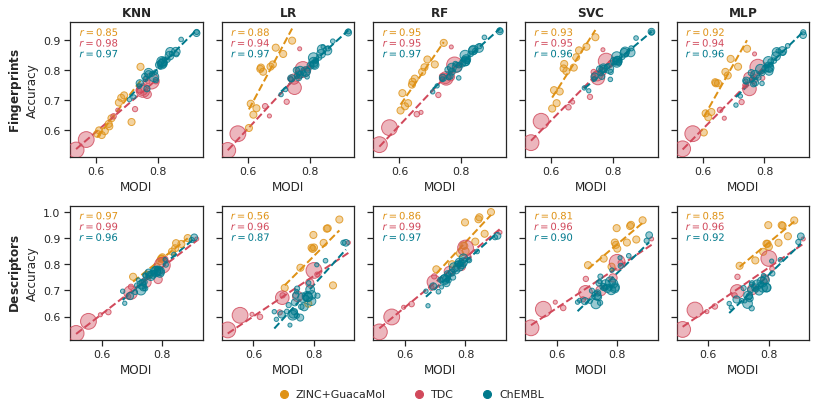

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11.5, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

METRIC = 'test_accuracy'
s = 'modi'
    

REPR = 'FPS'
# --------------------
# ZINC + FINGERPRINTS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, accuracy, title=f'$\\bf{m}$', marker='o', s=50, # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + FINGERPRINTS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + FINGERPRINTS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[0,i], scores, accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
REPR = 'DESC'
# --------------------
# ZINC + DESCRIPTORS
# --------------------
DATASET = 'ZINC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, accuracy, title='', marker='o', s=50, 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[0], edgecolor=colors[0], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[0], x_text=0.37, y_text=0.9, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')

# -------------------
# TDC + DESCRIPTORS
# -------------------
DATASET = 'TDC'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=0.37, y_text=0.82, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# -------------------
# TILBORG + DESCRIPTORS
# -------------------
DATASET = 'CHEMBL'
nametags = RESULTS[DATASET][REPR].keys()
scores = [RESULTS[DATASET][REPR][p][s] for p in nametags]
sizes = [RESULTS[DATASET][REPR][p]['size'] for p in nametags]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS[DATASET][REPR][p][m][METRIC]) for p in nametags])
    plot_scatter(axes[1,i], scores, accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], 
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[2], edgecolor=colors[2], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[2], x_text=0.37, y_text=0.74, dy_text=0.1, fontsize=10,
                 zorder_scatter=5, label='')
    
    
# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nAccuracy')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nAccuracy')

for i in range(2):
    for j in range(5):
        axes[i,j].set_xlabel(s.upper())
        axes[i,j].set_xlabel(s.upper())


# legend
ms = 8
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label='ZINC+GuacaMol', markerfacecolor=colors[0], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label='TDC', markerfacecolor=colors[1], markersize=ms),
                   Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label='ChEMBL', markerfacecolor=colors[2], markersize=ms)]

#fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
lgd = fig.legend(handles=legend_elements, loc='lower center', ncol=3, handletextpad=0.1,
                 bbox_to_anchor=(0.5, -0.05), frameon=False, bbox_transform=fig.transFigure)

plt.tight_layout()
fig.savefig(f'plots/binarized_regression-{s}.pdf', bbox_inches='tight')
fig.savefig(f'plots/binarized_regression-{s}.png', dpi=600, bbox_inches='tight')